In [28]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
import math
from scipy.spatial.transform import Rotation as Rot


In [29]:
#read data from the Memory_1.pkl file
memory_path = '/home/camillo/workspace/Learning/scripts/Memory_1.pkl'
with open(memory_path, 'rb') as f:
            memory = pickle.load(f)

In [30]:
memory.keys()

dict_keys(['hole_pose', 'hole_color', 'EE_pose', 'Dataset'])

In [31]:
(memory['Dataset'].shape)

(13218, 20)

In [32]:
#definition of some useful function

#segmentation function --> author: Aayush Jain

def Moving_average(object, window_size):
    i = 0
    moving_averages = []
    while i < len(object) - window_size + 1:
        window_average = round(np.sum(object[i:i+window_size]) / window_size, 1)
        moving_averages.append(window_average)
        i += 1
    avg = np.array(moving_averages)
    return avg

def Data_segmentation(dataset):
    print("Preparing data for segmentation")
    # with open(memory_path, 'rb') as f:
    #     memory = pickle.load(f)
    bag_time = dataset[:,0]
    Dtraj_x = dataset[:,1]
    Dtraj_y = dataset[:,2]
    Dtraj_z = dataset[:,3]

    execution_time = (bag_time[-1] - bag_time[0])
    print(execution_time)
    dt = execution_time/(len(Dtraj_x))
    linear_V_x= np.empty(len(Dtraj_x))
    linear_V_y= np.empty(len(Dtraj_y))
    linear_V_z= np.empty(len(Dtraj_z))
    iii=0
    for iii in range (len(Dtraj_x)):
        linear_V_x[iii]= (Dtraj_x[iii]-Dtraj_x[iii-1])/dt
        linear_V_y[iii]= (Dtraj_y[iii]-Dtraj_y[iii-1])/dt
        linear_V_z[iii]= (Dtraj_z[iii]-Dtraj_z[iii-1])/dt
    
    linear_V = np.abs(linear_V_x) + np.abs(linear_V_y) + np.abs(linear_V_z)
    avg = Moving_average(linear_V, 20)
    linear_V_nz= np.empty(len(avg))
    ii=0
    indexes = np.argwhere(avg > 0)

    while ii in range(len(indexes)):
        ind = indexes[ii]
        linear_V_nz [ind]= 1
        ii = ii+1
    print("Data prepared")
    return linear_V_nz, linear_V

def Segmentation_2(dataset, model):
    data, linear = Data_segmentation(dataset)
    penalty_value = 50
    print("Segmentation in process")
    training = rpt.KernelCPD(model).fit(data[1:])
    result = training.predict(pen=penalty_value)
    segments = np.array(result[:], dtype=int)
    print("Segmentation complete")

    # segments_sorted = []
    # for i in range(1,len(segments)):
    #     if Grip[segments[i-1]] == Grip[segments[i]]:
    #         if data[segments[i-1]+round((segments[i]-segments[i-1])/2)] != 1.0:
    #             pass
    #         else:
    #             segments_sorted.append(segments[i-1])
    #     else:
    #         segments_sorted.append(segments[i-1])
    # segments_sorted.append(segments[-1])
    # segments_sorted = [0]+segments_sorted
    # plt.figure(dpi=1200)
    rpt.display(data[:], segments)
    # # plt.figure(dpi=1200)
    # plt.savefig('/home/arscontrol/catkin_cisc_it/scripts/Offline_learning/my_plot.png', dpi = 1200)
    plt.show() 
    # plt.savefig('/home/arscontrol/catkin_cisc_it/scripts/Offline_learning/my_plot.png')
    return segments

Preparing data for segmentation
26.4336576461792
Data prepared
Segmentation in process
Segmentation complete


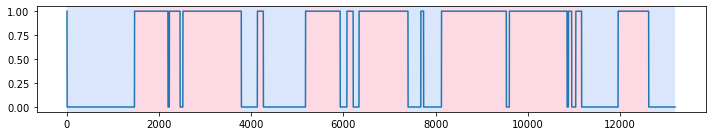

[ 1464  3782  4130  4260  5175  5927  6073  6209  6336  7399  8125 11166
 11958 12622 13198]


In [33]:
# %matplotlib qt
segments = Segmentation_2(memory['Dataset'], "rbf")
print(segments)

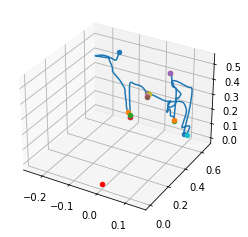

In [34]:
%matplotlib qt
ax = plt.figure().add_subplot(projection='3d')
ax.plot(memory['Dataset'][:,1], memory['Dataset'][:,2], memory['Dataset'][:,3], label='parametric curve')
ax.scatter(0,0,0, color='r')
[ax.scatter(memory['Dataset'][segments[i],1], memory['Dataset'][segments[i],2], memory['Dataset'][segments[i],3]) for i in range(len(segments))]
# ax.axis('equal')
# plt.show()

In [35]:
# memory_path_2 = '/home/camillo/workspace/Learning/scripts/Memory_1.pkl'
# with open(memory_path_2, 'rb') as f:
#             memory_2 = pickle.load(f)
memory_2 = memory
memory_2.keys()

dict_keys(['hole_pose', 'hole_color', 'EE_pose', 'Dataset'])

In [36]:
# print(type(memory_2['hole_pose'].poses[0]))
print(memory_2['EE_pose'])

layout: 
  dim: 
    - 
      label: "height"
      size: 4
      stride: 16
    - 
      label: "width"
      size: 4
      stride: 4
  data_offset: 0
data: [-0.08002053287360261, 0.46319118132624154, 0.6733383386785249, 0.6085614705221867, 0.7749182599930269, 0.08991744478785937, -0.14515329844022049]


In [37]:
hole_poses = []
for i in range(len(memory_2['hole_pose'].poses)):
    x = memory_2['hole_pose'].poses[i].position.x
    y = memory_2['hole_pose'].poses[i].position.y
    z = memory_2['hole_pose'].poses[i].position.z
    # qx = 0
    # qy = 0
    # qz = 0
    # qw = 1
    # c = memory_2['hole_color'][i]

    # here the orientation of the EE during the image acquisition phase is used instead of the orientation obtained
    # using the normal surface of the each hole -->
    # why? --> at this phase the normal comutation is not reliable and the obtained orientation is not usable
    qx = memory_2['EE_pose'].data[3]
    qy = memory_2['EE_pose'].data[4]
    qz = memory_2['EE_pose'].data[5]
    qw = memory_2['EE_pose'].data[6]
    #the color marker is added to the hole_poses data structure as the 8th element
    c = memory_2['hole_color'][i]
    hole_poses.append([x,y,z,qx,qy,qz,qw,c])

#debug prints   
#print(hole_poses)
#print(len(hole_poses))

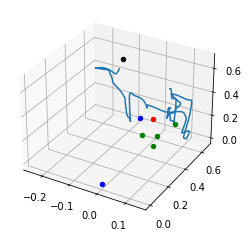

In [38]:
def quaternion_matrix(quaternion):
    r = Rot.from_quat(quaternion)
    matrix = r.as_matrix()
    matrix = np.column_stack((matrix, [0,0,0]))
    matrix = np.row_stack((matrix, [0,0,0,1]))
    return matrix

def Pose_2_mat(p):
    T = quaternion_matrix(p[3:])
    T[:3,3] = p[:3]
    return T

#camera frame w.r.t. EE frame --> constant transformation
CwrtEE =  [0.066, 0.097, -0.108, -0.074, 0.000, 0.997, -0.000] # got it from the ros2 run tf2_ros tf2_echo tool0 zivid_camera 

def transformation_to_base(hole_wrt_camera):
    # 'T' stand for transformation matrix (4x4)

    # hole w.r.t. camera frame
    cTo = Pose_2_mat(hole_wrt_camera[:-1])

    # camera w.r.t EE frame
    eeTc = Pose_2_mat(CwrtEE)

    # EE w.r.t. base frame
    bTee = Pose_2_mat(memory_2['EE_pose'].data)

    # hole w.r.t. EE frame
    eeTo = np.matmul(eeTc, cTo)

    # object w.r.t. base frame
    bTo = np.matmul(bTee, eeTo)

    rot_mat1 = Rot.from_matrix(bTo[:3,:3])  #extract the rotatinal part from the T matrix
    quat1 = rot_mat1.as_quat()  # convert from rot matrix to quaternion
    position1 = bTo[:3,3] # extract the translational part from the T matrix
    # pose of the hole in quaternion w.r.t. the base frame + the color marker as last element of the vector
    new_pose= np.concatenate((position1, quat1, [hole_wrt_camera[-1]]))

    return new_pose

# for each holes reprorject the pose (quaternion) from the camera frame to the base frame
hole_wrt_base = []
for i in range(len(hole_poses)):
    new_pose = transformation_to_base(hole_poses[i])
    hole_wrt_base.append(new_pose)
hole_wrt_base = np.array(hole_wrt_base) #cast to np.Array

# plot the position of the holes w.r.t. the base frame + the DEMO trajectory of the robot
color = ['g', 'g','g','g','r','b'] # color of the holes (hard wired...)
# %matplotlib qt
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(0,0,0, color='b')
ax.plot(memory['Dataset'][:,1], memory['Dataset'][:,2], memory['Dataset'][:,3], label='parametric curve')
# ax.scatter(memory['Dataset'][0,1], memory['Dataset'][0,2], memory['Dataset'][0,3], label='parametric curve', color = 'r')
ax.scatter(memory_2['EE_pose'].data[0], memory_2['EE_pose'].data[1], memory_2['EE_pose'].data[2], label='parametric curve', color='black')
[ax.scatter(hole_wrt_base[i][0], hole_wrt_base[i][1], hole_wrt_base[i][2], color=color[i]) for i in range(len(hole_wrt_base))]
# ax.set_box_aspect([1,1,1])  # Equal aspect ratio
plt.show()
    

In [39]:
#computing origin of the object

def normalize_vector(v):
    """Normalize a vector"""
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

# filter the pose of the red and blue marker holes
red_pose = hole_wrt_base[np.argwhere(hole_wrt_base[:,-1]==1.0)] # remove the last element (color marker no longer needed)
blue_pose = hole_wrt_base[np.argwhere(hole_wrt_base[:,-1]==3.0)]

# attach a frame to the ojbect with:
#   origin in the red marked hole
#   z-axis pointing upward --> paralel to the base frame z-axis
#   x-axis pass trougth the blue marked hole

direction = np.array([blue_pose[0][0][0] - red_pose[0][0][0], blue_pose[0][0][1] - red_pose[0][0][1]])
print(direction)

normalize_direction = normalize_vector(direction)

print(normalize_direction)

bTobj = np.zeros((4,4))
bTobj[0,0]= normalize_direction[0]
bTobj[0,1]= -normalize_direction[1]
bTobj[1,0]= normalize_direction[1]
bTobj[1,1]= normalize_direction[0]
bTobj[2,2] = 1
bTobj[3,3] = 1
bTobj[:3,3] = red_pose[0][0][:3]

print(bTobj)

[-0.04104642 -0.02756327]
[-0.83018805 -0.55748346]
[[-0.83018805  0.55748346  0.         -0.02260296]
 [-0.55748346 -0.83018805  0.          0.6418696 ]
 [ 0.          0.          1.          0.08464612]
 [ 0.          0.          0.          1.        ]]


In [40]:
screwing_holes = hole_wrt_base[np.argwhere(hole_wrt_base[:,-1]==0)] # filter all the green hole
print(screwing_holes.shape)

def transformation_to_obj(hole_wrt_base, bTobj):
    # hole pose with respect to base frame (in transformation matrix form)
    bTh = Pose_2_mat(hole_wrt_base[:-1])

    # base frame w.r.t. object frame
    objTb = np.linalg.inv(bTobj)

    # hole w.r.t. object frame
    objTh = np.matmul(objTb, bTh)

    # convert from T matrix to position+quaternion represetation
    rot_mat1 = Rot.from_matrix(objTh[:3,:3])
    quat1 = rot_mat1.as_quat() 
    position1 = objTh[:3,3]
    new_pose= np.concatenate((position1, quat1))

    return new_pose

# reproject all the green holes from base frame to object frame
hole_wrt_obj = []
for i in range(len(screwing_holes)):
    new_pose = transformation_to_obj(screwing_holes[i][0], bTobj)
    hole_wrt_obj.append(new_pose)
    print(new_pose)

# print(hole_wrt_obj)


(4, 1, 8)
[-0.05407894  0.08346382  0.04100886 -0.02876641  0.14291794 -0.30064147
  0.9425294 ]
[ 0.10101468  0.20397499  0.035242   -0.02876641  0.14291794 -0.30064147
  0.9425294 ]
[ 0.06466663  0.22147593 -0.03880965 -0.02876641  0.14291794 -0.30064147
  0.9425294 ]
[ 0.04522746  0.20376838  0.03699061 -0.02876641  0.14291794 -0.30064147
  0.9425294 ]


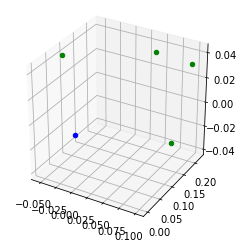

In [41]:
# %matplotlib qt
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(0,0,0, color='b')
[ax.scatter(hole_wrt_obj[i][0], hole_wrt_obj[i][1], hole_wrt_obj[i][2], color=color[i]) for i in range(len(hole_wrt_obj))]
ax.set_box_aspect([1,1,1])  # Equal aspect ratio
plt.show()
    

In [42]:
sequence = np.zeros((len(segments), len(screwing_holes)))
for i in range(len(segments)):
    for ii in range(len(screwing_holes)):
        print('ii', ii)
        dist = np.linalg.norm(memory['Dataset'][segments[i],1:4]-screwing_holes[ii][0][:3])
        if dist < 0.05:
            sequence[i,ii] = 1
        else:
            pass
print(sequence)



ii 0
ii 1
ii 2
ii 3
ii 0
ii 1
ii 2
ii 3
ii 0
ii 1
ii 2
ii 3
ii 0
ii 1
ii 2
ii 3
ii 0
ii 1
ii 2
ii 3
ii 0
ii 1
ii 2
ii 3
ii 0
ii 1
ii 2
ii 3
ii 0
ii 1
ii 2
ii 3
ii 0
ii 1
ii 2
ii 3
ii 0
ii 1
ii 2
ii 3
ii 0
ii 1
ii 2
ii 3
ii 0
ii 1
ii 2
ii 3
ii 0
ii 1
ii 2
ii 3
ii 0
ii 1
ii 2
ii 3
ii 0
ii 1
ii 2
ii 3
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [43]:
sequence_sorted = []
for i in range(1,len(sequence)):
    # if sequence[i-1].all() == 0.0:
    #     print('1')
    #     pass
    if np.array_equal(sequence[i], sequence[i-1]):
        print('3')
        pass
    else:
        
        print('2')
        if all(element == 0 for element in sequence[i-1]):
            pass
        else:
            sequence_sorted.append(sequence[i-1])
    
sequence_sorted = np.array(sequence_sorted)
print(sequence_sorted)


3
3
3
3
3
3
3
3
3
3
2
3
2
3
[[1. 0. 0. 0.]]


In [44]:
with open("/home/camillo/workspace/Learning/scripts/Memory_1.pkl", 'rb') as f:
    memory = pickle.load(f)

memory['hole_wrt_obj'] = hole_wrt_obj
memory['screwing_sequence'] = sequence_sorted
with open("/home/camillo/workspace/Learning/scripts/Memory_1.pkl", "wb") as fp:
      pickle.dump(memory, fp)

In [45]:
with open("/home/camillo/workspace/Learning/scripts/Memory_1.pkl", 'rb') as f:
    memory = pickle.load(f)
print(memory.keys())
print(memory['hole_wrt_obj'])
print(memory['screwing_sequence'])

dict_keys(['hole_pose', 'hole_color', 'EE_pose', 'Dataset', 'hole_wrt_obj', 'screwing_sequence'])
[array([-0.05407894,  0.08346382,  0.04100886, -0.02876641,  0.14291794,
       -0.30064147,  0.9425294 ]), array([ 0.10101468,  0.20397499,  0.035242  , -0.02876641,  0.14291794,
       -0.30064147,  0.9425294 ]), array([ 0.06466663,  0.22147593, -0.03880965, -0.02876641,  0.14291794,
       -0.30064147,  0.9425294 ]), array([ 0.04522746,  0.20376838,  0.03699061, -0.02876641,  0.14291794,
       -0.30064147,  0.9425294 ])]
[[1. 0. 0. 0.]]


In [46]:
def find_index_of_one_per_row(array):
    indexes = []
    for row in array:
        index = next((i for i, num in enumerate(row) if num == 1), -1)
        indexes.append(index)
    return indexes

order_indexes = find_index_of_one_per_row(memory['screwing_sequence'])
print(order_indexes)

sorted_holes = []
for i, ii in enumerate(order_indexes):
    print(ii)
    print(hole_wrt_obj[ii])
    sorted_holes.append(hole_wrt_obj[ii])
sorted_holes = np.array(sorted_holes)
print(sorted_holes)

with open("/home/camillo/workspace/Learning/scripts/Memory_1.pkl", 'rb') as f:
    memory = pickle.load(f)


memory['sorted_holes'] = sorted_holes
with open("/home/camillo/workspace/Learning/scripts/Memory_1.pkl", "wb") as fp:
      pickle.dump(memory, fp)
    
with open("/home/camillo/workspace/Learning/scripts/Memory_1.pkl", 'rb') as f:
    memory = pickle.load(f)
# print(memory.keys())
# print(memory['sorted_holes'])

# i can now use the sorted_holes defined in the object frame to control the robot and define a trajectory !!

[0]
0
[-0.05407894  0.08346382  0.04100886 -0.02876641  0.14291794 -0.30064147
  0.9425294 ]
[[-0.05407894  0.08346382  0.04100886 -0.02876641  0.14291794 -0.30064147
   0.9425294 ]]


In [47]:
# create a second .pkl file to only store the sorted holes
# for some unknown reason the ros2 node new_hole_detect.py cannot open the Memory_1.pkl file
# ' ModuleNotFoundError: No module named 'geometry_msgs.msg._PoseArray' '
memory_2 = {'sorted_holes': sorted_holes}
with open("/home/camillo/workspace/Learning/scripts/Memory_2.pkl", "wb") as fp:
    pickle.dump(memory_2, fp)

print('number of holes--> ',sorted_holes.shape[0])
print(memory_2['sorted_holes'])


number of holes-->  1
[[-0.05407894  0.08346382  0.04100886 -0.02876641  0.14291794 -0.30064147
   0.9425294 ]]
